In [1]:
from glob import glob
import librosa
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from pathlib import Path
from tensorflow.keras.utils import Sequence
from keras.saving import register_keras_serializable
import keras as K  # deconflict with tensorflow.keras


SPECTROGRAM_PATH="/mnt/md0/spectrograms"
fnames = glob("../birdsongs*/**/*mp3")
random.shuffle(fnames)
 
len(fnames)

2025-07-09 17:02:15.040830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752094935.209270   95209 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752094935.254442   95209 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752094935.503812   95209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752094935.503833   95209 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752094935.503835   95209 computation_placer.cc:177] computation placer alr

1372

In [7]:
def make_spectrograms(f):
    w = []
    THRESHOLD = 0.00003
     
    x,sr = librosa.load(f)
    y = librosa.feature.melspectrogram(y=x, n_mels=224,n_fft=4096*2, hop_length=128)
    z =[y[:, i:i+224] for i in range(0, y.shape[1]-224, 64)]
    w.append(np.stack(z))
    w = np.vstack(w)
    w= np.expand_dims(w, -1) # (batch, 224,224,1)

    filtered_w = []
    for img in w:
        if(np.sum(img**2)>THRESHOLD):
            filtered_w.append(img)
    w = np.array(filtered_w)
    for i, ww in enumerate(w):
        fname = f"{SPECTROGRAM_PATH}/{Path(f).stem}_{i}"
        arr = (ww - ww.min()) / (ww.max() - ww.min())
        np.save(fname, arr)
 
    return

for f in tqdm(fnames[:1200]):
    try:
        make_spectrograms(f)
    except Exception as e:
        print(e)
        


 15%|██████████▎                                                            | 175/1200 [02:41<15:30,  1.10it/s][src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
 28%|████████████████████▏                                                  | 341/1200 [05:19<06:42,  2.14it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!


need at least one array to stack


 33%|███████████████████████▎                                               | 394/1200 [06:02<11:12,  1.20it/s]Note: Illegal Audio-MPEG-Header 0x00000000 at offset 1678023.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 36%|█████████████████████████▌                                             | 433/1200 [06:32<06:33,  1.95it/s]Note: Illegal Audio-MPEG-Header 0x50455441 at offset 2435783.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 38%|██████████████████████████▊                                            | 453/1200 [06:44<07:44,  1.61it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!


need at least one array to stack


 51%|████████████████████████████████████▌                                  | 617/1200 [09:38<08:57,  1.09it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!


need at least one array to stack


 53%|█████████████████████████████████████▎                                 | 631/1200 [10:03<13:21,  1.41s/it]Note: Illegal Audio-MPEG-Header 0x65617220 at offset 494848.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 56%|███████████████████████████████████████▉                               | 676/1200 [10:42<09:29,  1.09s/it]Note: Illegal Audio-MPEG-Header 0x73206d65 at offset 372736.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
 86%|████████████████████████████████████████████████████████████▏         | 1032/1200 [17:07<03:46,  1.35s/it]Note: Illegal Audio-MPEG-Header 0x50455441 at offset 2165781.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
100%|██████████████████████████████████████████████████████████████████████| 1200/1200 [19:50<00:00,  1.01it/s]


In [8]:
x  = np.load(glob(f"{SPECTROGRAM_PATH}/*npy")[0])
x.max()

np.float32(1.0)

In [10]:
import numpy as np
from tensorflow.keras.utils import Sequence

class AutoencoderDataGenerator(Sequence):
    def __init__(self, fnames, batch_size, shuffle=True):
        """
        Initialize the data generator.
        
        Args:
            fnames (list): List of file paths to .npy files
            batch_size (int): Number of samples per batch
            shuffle (bool): Whether to shuffle the data after each epoch
        """
        self.fnames = fnames
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(fnames))
        self.on_epoch_end()

    def __len__(self):
        """Return the number of batches per epoch."""
        return int(np.ceil(len(self.fnames) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Get indices for the current batch
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Get list of filenames for the batch
        batch_fnames = [self.fnames[i] for i in batch_indices]
        
        # Load data
        X = self._load_data(batch_fnames)
        
        # Return (x, x) for autoencoder
        return X, X

    def _load_data(self, batch_fnames):
        """Load and preprocess data from .npy files."""
        # Initialize list to store batch data
        batch_data = []
        
        # Load each .npy file
        for fname in batch_fnames:
            # Load numpy array
            data = np.load(fname)
            batch_data.append(data)
        
        # Stack arrays into a batch (shape: (batch_size, 224, 224, 1))
        batch_data = np.stack(batch_data)
        
        # Optional: Normalize data to [0, 1] if needed
        # batch_data = batch_data / 255.0  # Uncomment if your data needs normalization
        
        return batch_data

    def on_epoch_end(self):
        """Shuffle indices after each epoch if shuffle is True."""
        if self.shuffle:
            np.random.shuffle(self.indices)

data_gen = AutoencoderDataGenerator(glob("/mnt/md0/spectrograms/*npy"), 32)
data_gen.num_batches

5700

In [11]:
x,x = data_gen.__getitem__(0)
x[0].max()

np.float32(1.0)

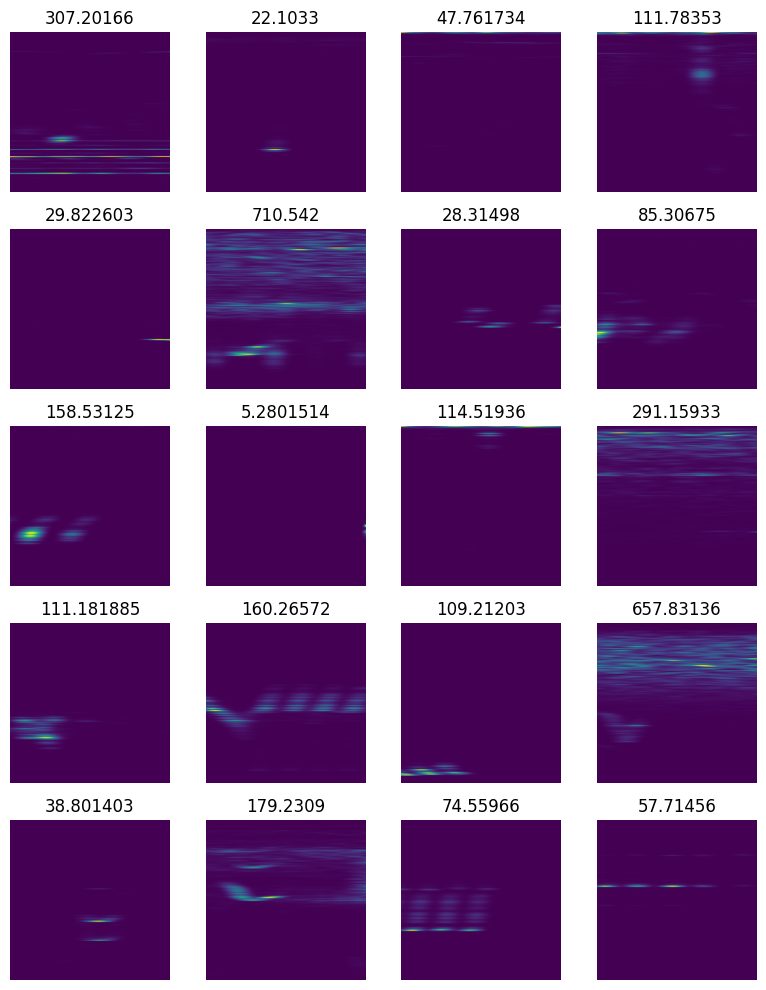

In [12]:
# visualize a few grams
 
images = x[:20,...]
fig, axes = plt.subplots(5, 4, figsize=(8, 10)) # 5 rows, 4 columns, adjust figsize as needed
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Iterate through images and display them
for i, img in enumerate(images):
    axes[i].imshow(img, ) # Using grayscale colormap for dummy images
    axes[i].axis('off') # Turn off axes for a clean display
    axes[i].set_title( str(np.sum(img**2)))
# Adjust layout for a tight display
plt.tight_layout()


In [ ]:
"""
VQ-VAE for 224×224×1 spectrograms
=================================
Stable training with:
  * EMA Vector-Quantiser
  * MSE reconstruction loss
  * Gradient-norm clipping
"""

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
try:
    import tensorflow_addons as tfa          # for GroupNorm
    GroupNorm = lambda: tfa.layers.GroupNormalization(groups=8)
except ImportError:
    GroupNorm = lambda: layers.BatchNormalization()

# --------------------------------------------------------------------- #
# 1.  Vector-Quantiser, EMA version (no trainable parameters)
# --------------------------------------------------------------------- #
@register_keras_serializable()
class VectorQuantizerEMA(layers.Layer):
    def __init__(self,
                 num_embeddings: int,
                 embedding_dim : int,
                 commitment_cost: float = 0.25,
                 decay: float = 0.99,
                 epsilon: float = 1e-5,
                 **kwargs):
        super().__init__(**kwargs)
        self.num_embeddings  = num_embeddings
        self.embedding_dim   = embedding_dim
        self.commitment_cost = commitment_cost
        self.decay           = decay
        self.epsilon         = epsilon

    def build(self, input_shape):
        # Code-book
        init = tf.random.uniform([self.num_embeddings, self.embedding_dim],
                                 minval=-1., maxval=1.)
        self.embeddings      = tf.Variable(init, trainable=False,
                                           name='embeddings')
        # EMA helpers
        self.ema_cluster_size = tf.Variable(tf.zeros([self.num_embeddings]),
                                            trainable=False)
        self.ema_embed = tf.Variable(init, trainable=False)

    def call(self, inputs, training=None):
        # inputs: [B, H, W, D]
        input_shape = tf.shape(inputs)
        flat_inputs = tf.reshape(inputs, [-1, self.embedding_dim])   # [BHW,D]

        # Squared Euclidean distance to every embedding
        distances = (tf.reduce_sum(flat_inputs**2, 1, keepdims=True)
                     - 2 * tf.matmul(flat_inputs, self.embeddings, transpose_b=True)
                     + tf.reduce_sum(self.embeddings**2, 1))

        encoding_indices = tf.argmin(distances, axis=1)              # [BHW]
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)  # [BHW,K]

        # Quantise and reshape back to image
        quantised = tf.matmul(encodings, self.embeddings)            # [BHW,D]
        quantised = tf.reshape(quantised, input_shape)

        # ------------------------------------------------------------------
        # EMA update of code-book (executed only in training mode)
        # ------------------------------------------------------------------
        if training:
            updated_cluster_size = tf.reduce_sum(encodings, axis=0)          # [K]
            dw = tf.matmul(encodings, flat_inputs, transpose_a=True)         # [K,D]

            self.ema_cluster_size.assign(self.decay * self.ema_cluster_size +
                                         (1. - self.decay) * updated_cluster_size)
            self.ema_embed.assign(self.decay * self.ema_embed +
                                  (1. - self.decay) * dw)

            n = tf.reduce_sum(self.ema_cluster_size)            # total elements
            cluster_size = ((self.ema_cluster_size + self.epsilon) /
                            (n + self.num_embeddings * self.epsilon)) * n
            normalized_embed = self.ema_embed / tf.expand_dims(cluster_size, 1)
            self.embeddings.assign(normalized_embed)

        # ------------------------------------------------------------------
        # Losses
        # ------------------------------------------------------------------
        commitment_loss = tf.reduce_mean(
            tf.square(tf.stop_gradient(quantised) - inputs))
        self.add_loss(self.commitment_cost * commitment_loss)

        # Straight-through estimator
        quantised = inputs + tf.stop_gradient(quantised - inputs)
        return quantised, tf.reshape(encoding_indices, input_shape[:3])  # indices for later use


# --------------------------------------------------------------------- #
# 2.  Encoder / Decoder building blocks
# --------------------------------------------------------------------- #
def enc_block(x, filters, stride=2):
    x = layers.Conv2D(filters, 4, strides=stride,
                      padding='same', use_bias=False)(x)
    x = GroupNorm()(x)
    return layers.LeakyReLU(0.2)(x)

def dec_block(x, filters):
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
    x = GroupNorm()(x)
    return layers.LeakyReLU(0.2)(x)


# --------------------------------------------------------------------- #
# 3.  Complete VQ-VAE model
# --------------------------------------------------------------------- #
def build_vqvae(input_shape=(224, 224, 1),
                embedding_dim=32,
                num_embeddings=512,
                beta=0.25):
    # ---------------- Encoder ---------------- #
    encoder_in  = keras.Input(shape=input_shape)
    x = enc_block(encoder_in,  32)    # 112×112
    x = enc_block(x,  64)             # 56×56
    x = enc_block(x, 128)             # 28×28
    x = enc_block(x, 256)             # 14×14
    x = layers.Conv2D(embedding_dim, 1, padding='same',
                      use_bias=False)(x)          # (14,14,32)
    encoder_out = x
    encoder = keras.Model(encoder_in, encoder_out, name='encoder')

    # -------------- Vector-Quantiser ---------- #
    vq_layer = VectorQuantizerEMA(num_embeddings,
                                  embedding_dim,
                                  commitment_cost=beta,
                                  name='vector_quantiser')

    # --------------- Decoder ------------------ #
    quant_in = keras.Input(shape=(14, 14, embedding_dim))
    y = dec_block(quant_in, 256)      # 28×28
    y = dec_block(y, 128)             # 56×56
    y = dec_block(y,  64)             # 112×112
    y = dec_block(y,  32)             # 224×224
    logits = layers.Conv2D(1, 3, padding='same')(y)   # raw logits
    decoder_out = layers.Activation('sigmoid')(logits)
    decoder = keras.Model(quant_in, decoder_out, name='decoder')

    # ------------- End-to-end Model ----------- #
    inputs = keras.Input(shape=input_shape)
    z_e = encoder(inputs)
    z_q, indices = vq_layer(z_e)
    recon = decoder(z_q)

    # ------------- End-to-end subclassed model -------------------- #
    @register_keras_serializable()
    class VQVAE(keras.Model):
        def __init__(self, encoder, vq_layer, decoder, **kwargs):
            super().__init__(**kwargs)
            self.encoder  = encoder
            self.vq_layer = vq_layer
            self.decoder  = decoder

            self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
            self.recon_loss_tracker = keras.metrics.Mean(name='recon_loss')
            self.vq_loss_tracker    = keras.metrics.Mean(name='vq_loss')

        # forward pass
        def call(self, x, training=False):
            z_e = self.encoder(x, training=training)
            z_q, _ = self.vq_layer(z_e, training=training)
            return self.decoder(z_q, training=training)

        # custom training loop
        def train_step(self, data):
            if isinstance(data, tuple):
                data = data[0]
            with tf.GradientTape() as tape:
                recon   = self(data, training=True)
                r_loss  = tf.reduce_mean(tf.square(data - recon))
                vq_loss = tf.add_n(self.vq_layer.losses)       # commitment term
                t_loss  = r_loss + vq_loss

            grads = tape.gradient(t_loss, self.trainable_variables)
            grads = [tf.clip_by_norm(g, 1.0) if g is not None else None
                     for g in grads]
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

            self.total_loss_tracker.update_state(t_loss)
            self.recon_loss_tracker.update_state(r_loss)
            self.vq_loss_tracker.update_state(vq_loss)
            return {'loss':        self.total_loss_tracker.result(),
                    'recon_loss':  self.recon_loss_tracker.result(),
                    'vq_loss':     self.vq_loss_tracker.result()}

        # (encode / decode helpers exactly as before)
        def encode(self, x):
            z_e = self.encoder(x, training=False)
            _, idx = self.vq_layer(z_e, training=False)
            return idx                        # shape (B,14,14)

        def decode_from_indices(self, indices):
            one_hot = tf.one_hot(indices, depth=num_embeddings)      # [B,14,14,K]
            flat    = tf.reshape(one_hot, [-1, num_embeddings])
            z_q = tf.matmul(flat, self.vq_layer.embeddings)          # [B*14*14,D]
            z_q = tf.reshape(z_q, [-1, 14, 14, embedding_dim])
            return self.decoder(z_q, training=False)

        def get_perplexity(self):
            """lower beta if perplexity is less than 10% (using few codes)"""
            probs = self.ema_cluster_size / tf.reduce_sum(self.ema_cluster_size)
            return tf.exp(-tf.reduce_sum(probs * tf.math.log(probs + 1e-10)))

        
        def get_config(self):
            config = super().get_config()
            config.update({
                "encoder": K.saving.serialize_keras_object(self.encoder),
                "vq_layer": K.saving.serialize_keras_object(self.vq_layer),
                "decoder": K.saving.serialize_keras_object(self.decoder)
            })
            return config
            
        @classmethod
        def from_config(cls, config):
            encoder = K.saving.deserialize_keras_object(config.pop("encoder"))
            vq_layer = K.saving.deserialize_keras_object(config.pop("vq_layer"))
            decoder = K.saving.deserialize_keras_object(config.pop("decoder"))
            return cls(encoder, vq_layer, decoder, **config)

    # create and return the model (NO positional tensors)
    return VQVAE(encoder, vq_layer, decoder, name='VQ_VAE')

# --------------------------------------------------------------------- #
# 4.  Build, compile, train
# --------------------------------------------------------------------- #
if __name__ == '__main__':
    # -------- data pipeline ------------------------------------------------
    # `data_gen` must yield float32 tensors in [0,1] of shape (224,224,1)
    BATCH  = 64
    STEPS  = 100_000 // BATCH          # one epoch = entire data set
    EPOCHS = 150

    #ds = (tf.data.Dataset.from_generator(lambda: data_gen,
    #        output_signature=tf.TensorSpec(shape=(224, 224, 1),
    #                                       dtype=tf.float32))
    #      .shuffle(1000)
    #      .batch(BATCH)
     #     .prefetch(tf.data.AUTOTUNE))

    # -------- build & compile ---------------------------------------------
    model = build_vqvae(input_shape=(224,224,1),
                        embedding_dim=32,
                        num_embeddings=768,
                        beta=0.25)

    model.compile(optimizer=keras.optimizers.Adam(3e-4, clipnorm=1.0))

    # -------- training -----------------------------------------------------
    # Early-stopping on reconstruction loss usually works well
    losses = ['recon_loss', 'loss', 'vq_loss']
    es = [keras.callbacks.EarlyStopping(patience=7,
                                       monitor=l, mode='min',
                                       restore_best_weights=True) for l in losses]

    model.fit(data_gen, epochs=EPOCHS,  callbacks=[es])

    # You now have a stable VQ-VAE with a 512-vector code-book.

Epoch 1/150
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 2376s 415ms/step - loss: 0.0071 - recon_loss: 0.0046 - vq_loss: 0.0024
Epoch 2/150
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 2367s 415ms/step - loss: 8.1861e-04 - recon_loss: 5.4672e-04 - vq_loss: 2.7189e-04
Epoch 3/150
5700/5700 ━━━━━━━━━━━━━━━━━━━━ 2365s 415ms/step - loss: 7.5338e-04 - recon_loss: 4.7050e-04 - vq_loss: 2.8288e-04
Epoch 4/150
4880/5700 ━━━━━━━━━━━━━━━━━━━━ 5:38 413ms/step - loss: 7.0869e-04 - recon_loss: 4.3054e-04 - vq_loss: 2.7815e-04

In [ ]:
n=10
y = model.encode(np.expand_dims(x[n],0))
y = model.encode(np.random.random((1,224,224,1)))
plt.matshow(y[0])
plt.figure()
plt.imshow(x[n])

In [ ]:
#model will now properly serialize/deserialize
model.save("vqvae_model.keras")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("vqvae_model.keras")

In [ ]:
fnames = glob("/home/gary/birdsongs/aldfly/*mp3")
 
f=fnames[0]
x,sr = librosa.load(f)
y = librosa.feature.melspectrogram(y=x, n_mels=224,n_fft=4096*2, hop_length=128)
arr = (y - y.min()) / (y.max() - y.min())
grams = [y[:,idx:idx+224] for idx in range(0, y.shape[1]-224, 5)]
grams = np.stack(grams)
       